In [256]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
import time

from model import Model
# from dataset import WheatAwnDataset

import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [257]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
class WheatAwnDataset(Dataset):
	""" dataset class for awn/awnless wheat data """

	def __init__(self, csv_filepath, dataset_dir, transform=None):
		"""	
		Keyword Argumens: 
			csv_filepath : str
				the path to the .csv dataset definition (key_file or similar)
			dataset_dir : str
				the path to the directory where the images are located
			transform : callable, optional (default is None)
				transform.compose() object with normalizations/data augmentation
		"""

		#make a dataframe from the csv file
		self.dataset_df = pd.read_csv(csv_filepath)

		#set the path for the root folder to the images of the dataset
		self.dataset_dir = dataset_dir

		#transforms object
		self.transform = transform

	def __len__(self):
		""" get the size of the dataframe """

		return len(self.dataset_df)

	def __getitem__(self, idx):
		""" collect images from the dataset """

		#find the image path and label in the df
		#note: class label (awned: 0, awnless: 1)
		image_path = self.dataset_df.iloc[idx, 0]
		label = self.dataset_df.iloc[idx, 1]

		#read the image with torch (returns a uint8 tensor)
		#no transforms.ToTensor() needed
		#https://github.com/pytorch/vision/issues/2788
		# image = read_image(image_path)

		#open image with PIL
		image = Image.open(image_path)

		#transform (data augmentation)
		if self.transform:
			image = self.transform(image)

		return image, label

### let's define the training procedure:
-expose the model to the data first to see what raw inits look like<br/>-then train/validate across epochs<br/>-save every so often<br/>-plot training progress (loss and accuracy)

In [258]:
def expose(model, epoch, dataloader, device, criterion, optimizer):
    print(f"EXPOSE      epoch: {epoch}")
    
    #track the loss across the epoch
    epoch_loss = 0.0

    #track the correct predictions
    corrects = 0.0

    #set model mode
    model.eval()

    #make sure to not accumulate gradients
    with torch.no_grad():

        for images, labels in dataloader:

            #send the tensors to the device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            #images = images.float() #uncomment if using read_image() from torch
            outputs = model(images) #float?

            #calculate the loss
            loss = criterion(outputs, labels)

            #add to the loss accumulated over the epoch
            epoch_loss += loss.item()

            #find the predicted classes indicies
            _, preds = torch.max(outputs, 1)

            #track the correct predictions (.item()to collect just the value)
            corrects += torch.sum(preds == labels.data).item()


    #calculate the total loss across the iterations of the loader
    epoch_loss = epoch_loss/len(dataloader)

    #calculate the accuracy 
    accuracy = (corrects/len(dataloader.dataset))*100

    #format the epoch loss/accuracy to look nice
    epoch_loss = "{:7.5f}".format(epoch_loss)
    accuracy = "{:5.2f}".format(accuracy)

    print(f"      ---> loss: {epoch_loss} accuracy: {accuracy}")

    return epoch_loss, accuracy





def train(model, epoch, dataloader, device, criterion, optimizer):
    print(f"[train]     epoch: {epoch}")

    #set model mode
    model.train()

    #track the loss across the epoch
    epoch_loss = 0.0

    #track the correct predictions
    corrects = 0.0

    for images, labels in dataloader:

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        #images = images.float() #uncomment if using read_image() from torch
        outputs = model(images)

        #calculate the loss
        loss = criterion(outputs, labels)

        #reset our gradients
        optimizer.zero_grad()

        #propagate backward
        loss.backward()

        #update weights
        optimizer.step()

        #add to the loss accumulated over the epoch
        epoch_loss += loss.item()

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()


    #calculate the total loss across the iterations of the loader
    epoch_loss = epoch_loss/len(dataloader)

    #calculate the accuracy 
    accuracy = (corrects/len(dataloader.dataset))*100

    #format the epoch loss/accuracy to look nice
    epoch_loss = "{:7.5f}".format(epoch_loss)
    accuracy = "{:5.2f}".format(accuracy)

    print(f"      ---> loss: {epoch_loss} accuracy: {accuracy}")

    return epoch_loss, accuracy

def validate(model, epoch, dataloader, device, criterion, optimizer):
    print(f"[validate]  epoch: {epoch}")

    #track the loss across the epoch
    epoch_loss = 0.0

    #track the correct predictions
    corrects = 0.0

    #set model mode
    model.eval()

    #make sure to not accumulate gradients
    with torch.no_grad():

        for images, labels in dataloader:

            #send the tensors to the device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            #images = images.float() #uncomment if using read_image() from torch
            outputs = model(images)

            #calculate the loss
            loss = criterion(outputs, labels)

            #add to the loss accumulated over the epoch
            epoch_loss += loss.item()

            #find the predicted classes indicies
            _, preds = torch.max(outputs, 1)

            #track the correct predictions
            corrects += torch.sum(preds == labels.data).item()


    #calculate the total loss across the iterations of the loader
    epoch_loss = epoch_loss/len(dataloader)

    #calculate the accuracy 
    accuracy = (corrects/len(dataloader.dataset))*100
    
    #format the epoch loss/accuracy to look nice
    epoch_loss = "{:7.5f}".format(epoch_loss)
    accuracy = "{:5.2f}".format(accuracy)

    print(f"      ---> loss: {epoch_loss} accuracy: {accuracy}")

    return epoch_loss, accuracy

In [259]:
def main():

    print('running...\n\n')
    current_time = time.strftime("%Y-%m-%d-%H_%M_%S")

    #set the 'device' customary var for the GPU (or CPU if not available)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print("(using device: ", device,")\n\n")


    #construct the datasets
    dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'

    #training data
    train_data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_tiny.csv'
    train_transform = transforms.Compose([transforms.RandomRotation(0.2),
                                          transforms.RandomCrop((224,224)),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([77.7395, 83.9253, 53.3458], [48.1450, 49.1999, 36.7069])])
    
    training_data = WheatAwnDataset(csv_filepath=train_data_csv, dataset_dir=dataset_path, transform=train_transform)
    train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)

    #validation data
    validation_data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns_tiny.csv'
    validation_transform = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize([77.7395, 83.9253, 53.3458], [48.1450, 49.1999, 36.7069])])
    
    validation_data = WheatAwnDataset(csv_filepath=validation_data_csv, dataset_dir=dataset_path, transform=validation_transform)
    validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)

    #build the model
    model = Model().construct_model(verbose=False)

    model = model.to(device)

    #loss function
    criterion = nn.CrossEntropyLoss()

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

    #set up lists to track training progress
    training_loss_history, training_accuracy_history = [],[]
    validation_loss_history, validation_accuracy_history = [], []

    #train the model across epochs
    epochs = 5

    for epoch in range(epochs):

        #make sure to expose the model first, with just the raw initilizations
        if epoch == 0:
            loss, accuracy = expose(model, epoch-1, train_dataloader, device, criterion, optimizer)
            training_loss_history.append(loss)
            training_accuracy_history.append(accuracy)

            loss, accuracy = expose(model, epoch-1, validation_dataloader, device, criterion, optimizer)
            validation_loss_history.append(loss)
            validation_accuracy_history.append(accuracy)

        #train
        loss, accuracy = train(model, epoch, train_dataloader, device, criterion, optimizer)
        training_loss_history.append(loss)
        training_accuracy_history.append(accuracy)

        #validate
        loss, accuracy = validate(model, epoch, validation_dataloader, device, criterion, optimizer)
        validation_loss_history.append(loss)
        validation_accuracy_history.append(accuracy)
        
        if epoch%5 == 0 and epoch != 0:
            #save the model (parameters only) every 5 epochs
            torch.save(model.state_dict(), f"/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/{current_time}_model_epoch-{epoch}.pth")
    
    #save final model and plot training history
    torch.save(model.state_dict(), f"/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/{current_time}_model_epoch-{epoch}.pth")
    
    fig = plt.figure(figsize=(20,8))

    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("Training/Validation Loss across Epochs")
    plt.plot(range(epochs+1), training_loss_history, label='train-loss')
    plt.plot(range(epochs+1), validation_loss_history, label= 'validation-loss')
    
    plt.ylabel('Training/Validation Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='best')

    ax = fig.add_subplot(1, 2, 2)
    ax.set_title("Training/Validation Accuracy across Epochs")
    plt.plot(range(epochs+1), training_accuracy_history, label='train-accuracy')
    plt.plot(range(epochs+1), validation_accuracy_history, label= 'validation-accuracy')
    plt.ylabel('Training/Validation accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    
    fig.suptitle(f"Training Run Loss/Accuracy History {current_time}")
    fig.savefig(f"/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/{current_time}_loss_accuracy-plot.jpg")

#### ..now actually run the training loop

running...


(using device:  cuda:0 )


EXPOSE      epoch: -1
      ---> loss: 0.71498 accuracy: 50.00
EXPOSE      epoch: -1
      ---> loss: 0.70779 accuracy: 50.00
[train]     epoch: 0
      ---> loss: 0.69133 accuracy: 54.00
[validate]  epoch: 0
      ---> loss: 0.69489 accuracy: 50.00
[train]     epoch: 1
      ---> loss: 0.69938 accuracy: 50.50
[validate]  epoch: 1
      ---> loss: 0.69281 accuracy: 52.50
[train]     epoch: 2
      ---> loss: 0.69097 accuracy: 53.50
[validate]  epoch: 2
      ---> loss: 0.69159 accuracy: 50.00
[train]     epoch: 3
      ---> loss: 0.68750 accuracy: 52.50
[validate]  epoch: 3
      ---> loss: 0.69011 accuracy: 50.00
[train]     epoch: 4
      ---> loss: 0.70101 accuracy: 48.00
[validate]  epoch: 4
      ---> loss: 0.68873 accuracy: 50.00


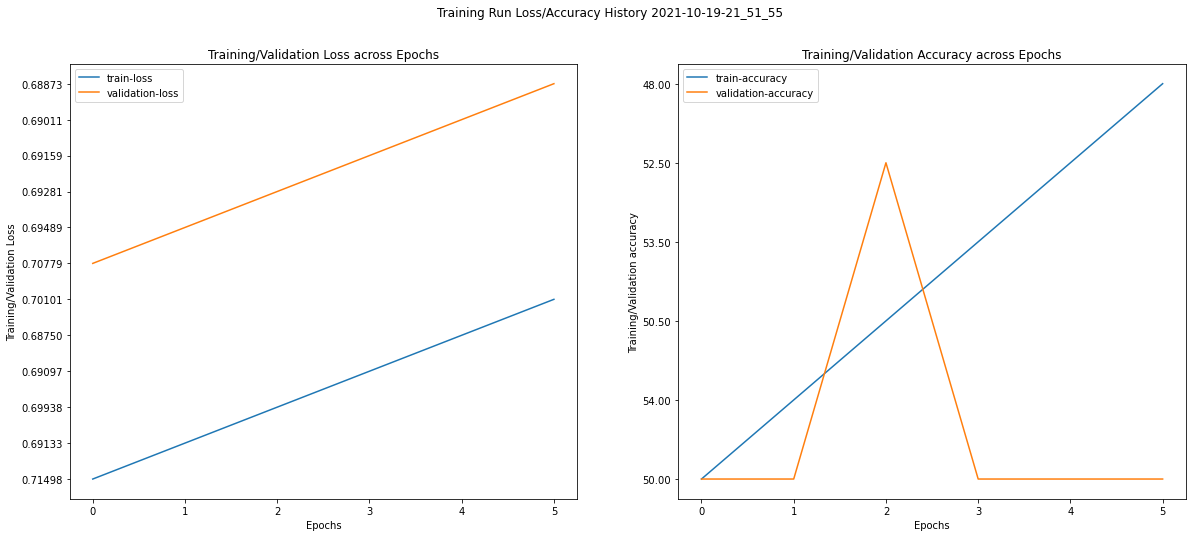

In [260]:
main()

## Visualize the Training Progress 
-on fixed axes!<br/>-training and validation progress on the same graph!

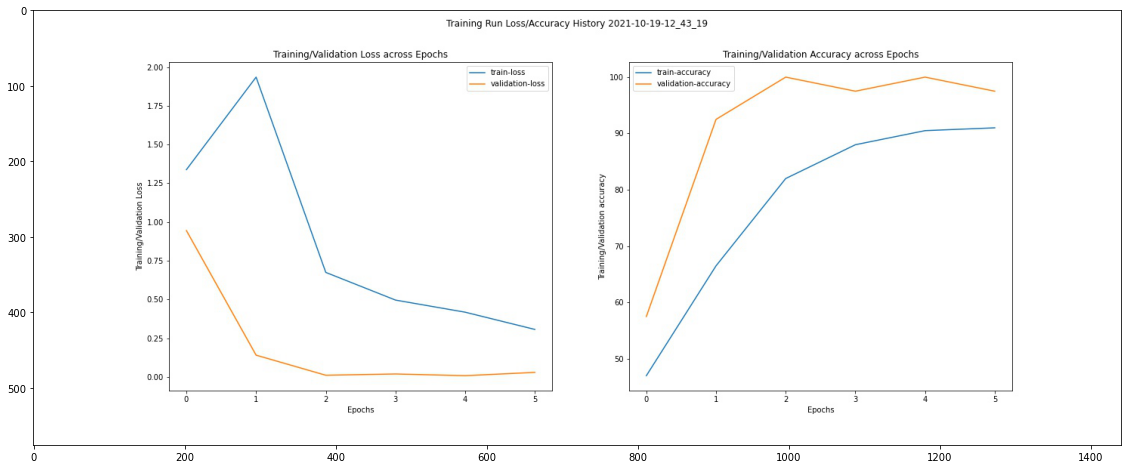

In [111]:
import PIL

#sort files
search_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
os.chdir(search_dir)
files = filter(os.path.isfile, os.listdir(search_dir))
files = [os.path.join(search_dir, f) for f in files]# add path to each file

files = [file for file in files if file.endswith('.jpg')]
files.sort(key=lambda x: os.path.getmtime(x))

#show the most recent training plot
plot_img = PIL.Image.open(files[-4])
plt.figure(figsize = (20,8))
plt.imshow(plot_img)

### Test the Ability to Load a Trained Model
-get predictions on data<br/>-visualize

In [148]:
#sort files in runs dir
search_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
os.chdir(search_dir)
files = filter(os.path.isfile, os.listdir(search_dir))
files = [os.path.join(search_dir, f) for f in files]# add path to each file

files = [file for file in files if file.endswith('.pth')] #only get model files
files.sort(key=lambda x: os.path.getmtime(x))

#instantiate the most recent model
print(f"loading model from: {files[-1]}")
saved_model = Model().construct_model(verbose=False)
saved_model.load_state_dict(torch.load(files[-1]))


loading model from: /pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-19-13_16_11_model_epoch-4.pth


<All keys matched successfully>

In [201]:
#collect dataset and create loader iterable-object
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns_tiny.csv'
batch_size = 8

transform = None
data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [202]:
def imshow(img):
    '''helper fn stolen from pytorch.org tutorial :)'''
    npimg = img.numpy()
    plt.figure(figsize = (20,8))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
    plt.show()

In [203]:
#note class label (awned: 0, awnless: 1)
classes = ('awned', 'awnless')

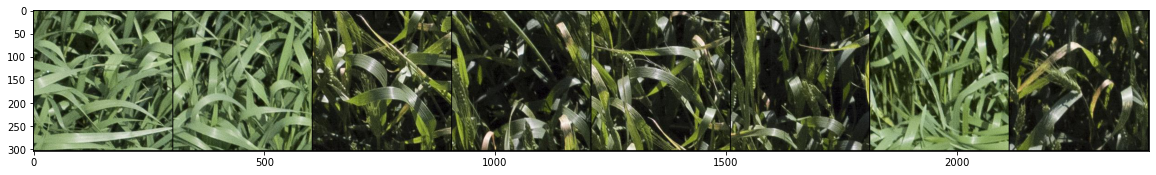

Ground Truth:  awned - awned - awnless - awnless - awnless - awnless - awned - awnless


In [204]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ',' - '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [205]:
images = images.float()
outputs = saved_model(images)

In [206]:
_, preds = torch.max(outputs, 1)
print('Predicted: ', ' - '.join('%5s' % classes[preds[j]] for j in range(batch_size)))

Predicted:  awned - awned - awnless - awnless - awnless - awnless - awned - awnless


In [220]:
#conf matrix from: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
from sklearn.metrics import confusion_matrix

# Get the predictions
predictions = []
ground_truths = []

for images, labels in dataloader:
    images = images.float()
    outputs = saved_model(images)
    _, preds = torch.max(outputs, 1)
    
    ground_truths.extend(list(labels.numpy()))
    predictions.extend(list(preds.numpy()))

print("predictions:   ", len(predictions))
print("ground truths: ", len(ground_truths))

predictions:    40
ground truths:  40


In [226]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=ground_truths, y_pred=predictions)

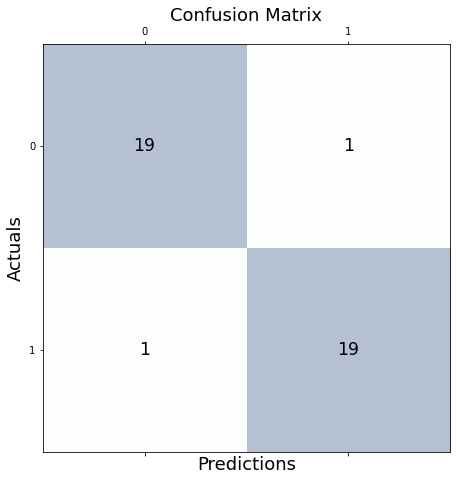

In [227]:
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### We should also calculate the mean and standard deviation of the dataset to normalize for training
normalization values found for training dataset: (tensor([77.7395, 83.9253, 53.3458]), tensor([48.1450, 49.1999, 36.7069]))

In [187]:
#calculate the mean and standard deviation of the dataset
#from here: https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    prog_bar = tqdm.tqdm(dataloader, total=int(len(dataloader)), desc='prog: ')
    
    for step, data in enumerate(prog_bar):
        # Mean over batch, height and width, but not over the channels
        data = data[0]
        data = data.float()
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [188]:
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
# data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns.csv'
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_oversampled.csv'

batch_size = 64

transform = None
data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [189]:
len(dataloader)

7070

In [190]:
get_mean_and_std(dataloader)


prog:   4%|▎         | 265/7070 [06:37<2:23:49,  1.27s/it]


prog:   7%|▋         | 529/7070 [13:08<2:53:16,  1.59s/it]


prog:  11%|█         | 793/7070 [19:44<2:44:58,  1.58s/it]


prog:  15%|█▍        | 1056/7070 [26:25<2:25:44,  1.45s/it]


prog:  19%|█▊        | 1316/7070 [32:54<2:18:27,  1.44s/it]


prog:  22%|██▏       | 1576/7070 [39:17<2:11:21,  1.43s/it]


prog:  26%|██▌       | 1836/7070 [45:51<2:29:07,  1.71s/it]


prog:  30%|██▉       | 2096/7070 [52:22<1:59:30,  1.44s/it]


prog:  33%|███▎      | 2356/7070 [58:46<1:58:54,  1.51s/it]


prog:  37%|███▋      | 2609/7070 [1:05:07<2:04:31,  1.67s/it]


prog:  40%|████      | 2861/7070 [1:11:30<1:43:16,  1.47s/it]


prog:  44%|████▍     | 3113/7070 [1:17:43<1:34:16,  1.43s/it]


prog:  48%|████▊     | 3365/7070 [1:24:04<1:42:45,  1.66s/it]


prog:  51%|█████     | 3617/7070 [1:30:20<1:30:06,  1.57s/it]


prog:  55%|█████▍    | 3869/7070 [1:36:23<1:02:53,  1.18s/it]


prog:  58%|█████▊    | 4121/7070 [1:42:39<1:09:41,  1.42s/it]


prog:  62%|██████▏   | 4373/7070 [1:48:55<1:04:10,  1.43s/it]


prog:  65%|██████▌   | 4625/7070 [1:55:07<1:10:53,  1.74s/it]


prog:  69%|██████▉   | 4882/7070 [2:01:28<1:01:53,  1.70s/it]


prog:  73%|███████▎  | 5141/7070 [2:07:53<47:50,  1.49s/it]


prog:  76%|███████▋  | 5400/7070 [2:14:27<42:23,  1.52s/it]


prog:  80%|████████  | 5660/7070 [2:20:09<35:42,  1.52s/it]


prog:  84%|████████▎ | 5920/7070 [2:25:07<20:28,  1.07s/it]


prog:  87%|████████▋ | 6180/7070 [2:30:02<17:59,  1.21s/it]


prog:  91%|█████████ | 6440/7070 [2:34:53<10:47,  1.03s/it]


prog:  95%|█████████▍| 6700/7070 [2:39:42<07:30,  1.22s/it]


prog:  98%|█████████▊| 6960/7070 [2:44:29<01:59,  1.08s/it]


prog: 100%|██████████| 7070/7070 [2:46:27<00:00,  1.41s/it]


(tensor([77.7395, 83.9253, 53.3458]), tensor([48.1450, 49.1999, 36.7069]))